In [1]:
!pip install pennylane --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 72.8 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer, GradientDescentOptimizer, MomentumOptimizer
import tensorflow as tf

In [3]:
#******************************************
# Data import
#******************************************

# import train, dev and test datasets: the data entries are all strings of the form 'label sentence' 
# with the label in {0,1} and with the sentence of the form "word1_POStag1 word2_POStag2 ..."

with open('/kaggle/input/mc-and-rp-dataset-for-quantum-computing-qnlp/mc_train_data.txt') as f:
    training_data_raw = f.readlines()

with open('/kaggle/input/mc-and-rp-dataset-for-quantum-computing-qnlp/mc_dev_data.txt') as f:
    dev_data_raw = f.readlines()

with open('/kaggle/input/mc-and-rp-dataset-for-quantum-computing-qnlp/mc_test_data.txt') as f:
    testing_data_raw = f.readlines()
#***************************************************************
# Turn the raw input data into data structures convenient below
#***************************************************************

vocab = dict()          # dictionary to be filled with the vocabulary in the form { word : POStag }
data = dict()           # dictionary to be filled with all the data (train, dev and test subsets); entries of the 
                        # form { sentence : label } with label encoding '1' as [1.0, 0.0] and '0' as [0.0, 1.0]
training_data = []      # list of sentences in the train dataset as strings "word1 word2 ..."
dev_data = []           # list of sentences in the dev dataset as strings "word1 word2 ..."
testing_data = []       # list of sentences in the test dataset as strings "word1 word2 ..."
training_data_label = []      # list of sentences in the train dataset as strings "word1 word2 ..."
dev_data_label = []           # list of sentences in the dev dataset as strings "word1 word2 ..."
testing_data_label = []
# Go through the train data
for sent in training_data_raw:
    words = sent[2:].split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    training_data.append(sentence)
    label = 1.0 if sent[0] == '1' else -1.0
    training_data_label.append(label)

# Go through the dev data
for sent in dev_data_raw:
    words = sent[2:].split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    dev_data.append(sentence)
    label = 1.0 if sent[0] == '1' else -1.0
    dev_data_label.append(label)
    
# Go through the test data
for sent in testing_data_raw:
    words = sent[2:].split() 
    sent_untagged = ''
    for word in words:
        word_untagged, tag = word.split('_')
        vocab[word_untagged] = tag
        sent_untagged += word_untagged + ' '
    sentence = sent_untagged[:-1]
    testing_data.append(sentence)
    label = 1.0 if sent[0] == '1' else -1.0
    testing_data_label.append(label)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

def embedding_sentece(data_list):
    sentences = data_list
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)  
    word_index = tokenizer.word_index  
    vocab_size = len(word_index) + 1  # Số lượng từ vựng (+1 cho padding)
    sequences = tokenizer.texts_to_sequences(sentences)

    max_length = max(len(seq) for seq in sequences)  # Độ dài tối đa
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    
    embedding_dim = 4  # Chọn số chiều của vector embedding
    
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)
    ])
    
    output = model.predict(padded_sequences)
    return output
X = np.array(embedding_sentece(training_data), dtype='float64')
Y = np.array(training_data_label)
X_dev = np.array(embedding_sentece(dev_data), dtype='float64')
Y_dev = np.array(dev_data_label)
X_test = np.array(embedding_sentece(testing_data), dtype='float64')
Y_test = np.array(testing_data_label)
X = X.reshape(-1,16)
X_dev = X_dev.reshape(-1,16)
X_test = X_test.reshape(-1,16)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


In [4]:
X = X[:50]
Y = Y[:50]

In [5]:
dev = qml.device('default.qubit', wires=17)

def state_preparation(f=None):
    qml.AmplitudeEmbedding(features=f, wires=[0,1,2,3], normalize=True)
    qml.AmplitudeEmbedding(features=f, wires=[4,5,6,7], normalize=True)
    qml.AmplitudeEmbedding(features=f, wires=[8,9,10,11], normalize=True)

In [6]:
def unitary_embedding(theta_list: list):
  '''
  theta_list: list of theta
  '''
  for i in range(len(theta_list)):
    qml.RY(theta_list[i], wires=[i])
  for i in range(len(theta_list)-1):
    c = i
    if c == len(theta_list)-1:
      f = 0
    else:
      f = c+1
    qml.CNOT(wires=[c,f])

In [7]:
def combine_unitary_embedding(number_layer, theta_list):
  '''
  len(theta_list) = number_layer
  theta_list elem = 
  '''
  for i in range(len(theta_list[0])):
    qml.H(wires=[i])
  for layer in range(number_layer):
    unitary_embedding(theta_list[layer])

In [8]:
def barbell_operation(wires_1, wires_2):
  '''
  swap Q to second register group
  '''
  for i, j in zip(wires_1, wires_2):
    qml.SWAP(wires=[i,j])

In [9]:
def QLS_module(wires_control_1, wires_control_2, wires_result):
  for i, j, k in zip(wires_control_1, wires_control_2, wires_result):
    qml.Toffoli(wires=[i,j,k])
  for i in range(len(wires_result)-2):
    qml.CNOT(wires=[wires_result[i],wires_result[i+1]])

In [10]:
def multicontrol_slice(wires_qls, wires_q):
  for i in wires_q:
    qml.MultiControlledX(wires=[*wires_qls,i])
# print(qml.draw(multicontrol_slice)([12,13,14,15], [0,1,2,3]))

In [11]:
def swap_test_layer(wires_1, wires_2, controll_wires):
    qml.H(wires=controll_wires)
    for w1, w2 in zip(wires_1, wires_2):
        qml.CSWAP(wires=[controll_wires,w1,w2])
    qml.H(wires=controll_wires)

In [12]:
# define circuit and start train and implement
@qml.qnode(dev)
def full_circuit(x, weights,parameters, num_layers=1):
  '''
  weight = [theta_q, theta_k, theta_v]
  3x4
  theta_q: 4x1
  theta_k: 4x1
  theta_v: 4x1

  '''
  state_preparation(f=x)
  # step 1: prepare Q
  combine_unitary_embedding(number_layer=num_layers, theta_list=weights[0])
  # step 2: swap Q and register
  wires_1 = [0,1,2,3]
  wires_2 = [4,5,6,7]
  barbell_operation(wires_1, wires_2)

  # step 3: prepare K
  combine_unitary_embedding(number_layer=num_layers, theta_list=weights[1])

  # step 4: swap K
  wires_1 = [0,1,2,3]
  wires_2 = [8,9,10,11]
  barbell_operation(wires_1, wires_2)

  # step 5: QLS Module
  wires_control_1, wires_control_2, wires_result = [0,1,2,3], [4,5,6,7], [12,13,14,15]
  QLS_module(wires_control_1, wires_control_2, wires_result)


  #step 6: prepare V
  combine_unitary_embedding(number_layer=num_layers, theta_list=weights[2])

  # step 7: the entanglement compression operation
  # do nothing if n == 1

  # step 8: slicing operation
  wires_qls, wires_q = [12,13,14,15], [4,5,6,7]
  multicontrol_slice(wires_qls, wires_q)

  # step 8.2: swap test operation
  # wires_qls, wires_q = [12,13,14,15], [0,1,2,3]
  # controll_qubit = 16
  # swap_test_layer(wires_qls, wires_q, controll_qubit)
  # step8.3: another QNN
  qml.StronglyEntanglingLayers(weights=parameters, wires=range(8))
  # step 9: meseaurement
  observable = qml.PauliZ(0)
  return qml.expval(observable)

In [13]:
# test circuit
shape = qml.StronglyEntanglingLayers.shape(n_layers=16, n_wires=8)
parameters = np.random.random(size=shape)
print(parameters.shape)
n_layers = 1
weights = 0.01 * np.random.randn(3,n_layers,4, requires_grad=True)
params = (weights, parameters)

(16, 8, 3)


In [14]:
X_batch = X
Y_batch = Y
X_test_batch = X_test
Y_test_batch = Y_test

<h1> Cost Function and Opimizer </h1>

In [15]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc
    
def cost(*args, **kwargs):
    # Extract the parameters and data from *args and **kwargs
    weights = args[0]  # Assuming the first argument is the parameters (usually a NumPy array)
    parameters = args[1]
    X = kwargs.get('X', None)  # Get X from kwargs, default to None if not provided
    Y = kwargs.get('Y', None)  # Get Y from kwargs, default to None if not provided
    predictions = [full_circuit(x=x, weights=weights,parameters=parameters) for x in X]
    return np.mean((Y - qml.math.stack(predictions)) ** 2)

In [16]:
print(len(X))
print(len(Y))
print(len(X_test))
print(len(Y_test))

50
50
30
30


In [17]:
import matplotlib.pyplot as plt
def draw_result(current_cost_list,acc_list,test_acc_list,epoch,lrate,n_layers=1):
    fig, axs = plt.subplots(3, 1, figsize=(12, 10))
    axs[0].plot(epoch, current_cost_list,label=f'loss_{lrate}')
    axs[0].set_title(f'Loss {n_layers}')
    axs[0].set_xlabel('Epoch')  # Set x-axis label
    axs[0].set_ylabel('Cost Function')  # Set y-axis label
    axs[0].legend()
    axs[1].plot(epoch, acc_list, label=f'train_acc_{lrate}')
    axs[1].set_title(f'Train acc {n_layers}')
    axs[1].set_xlabel('Epoch')  # Set x-axis label
    axs[1].set_ylabel('Train Accuraccy')  # Set y-axis label
    axs[1].legend()
    axs[2].plot(epoch, test_acc_list,label=f'test_acc_{lrate}')
    axs[2].set_title(f'Test acc {n_layers}')
    axs[2].set_xlabel('Epoch')  # Set x-axis label
    axs[2].set_ylabel('Test Accuraccy')  # Set y-axis label
    axs[2].legend()
    fig.subplots_adjust(hspace=0.5)
    fig.tight_layout()
    plt.show()
    fig.savefig(f"/kaggle/working/chart_nlayer{n_layers}_lrate{lrate}.png")

In [18]:
def make_drop_out_parameter(parameter, drop_rate):
    '''
    caculate gradient based on dropped gate
    update gradient without dropped gate
    update on true parameter
    '''
    param_shape = parameter.shape
    total_elem = param_shape[0] * param_shape[1]
    num_selected = int(drop_rate * total_elem)  # 30% of 64 = 19
    
    # Flatten the matrix, randomly select 19 indices
    flat_indices = np.random.choice(total_elem, num_selected, replace=False)
    
    # Create a mask of zeros and set selected positions to 1
    index_matrix = np.zeros(total_elem, dtype=bool)
    index_matrix[flat_indices] = True
    index_matrix = index_matrix.reshape(param_shape[0], param_shape[1])  # Reshape back to 8×8
    masked_matrix = np.ones(param_shape, dtype=int)  # Initialize with zeros
    masked_matrix[index_matrix,:] = 0  # Set every second row to 1
    dropped_param = parameter * masked_matrix
    return dropped_param, masked_matrix

In [19]:
params[0]

tensor([[[-0.00432095,  0.02142852, -0.01284662,  0.02020107]],

        [[ 0.00765362, -0.01377284, -0.00122712, -0.02257756]],

        [[ 0.01490356, -0.00190573, -0.00689316,  0.00254546]]], requires_grad=True)

In [20]:
current_cost = cost(params[0],params[1], X=X, Y=Y)

number layers: 1
Iter:    1 | Cost: 1.0076415 | Accuracy: 0.4600000 | Test Accuracy: 0.7000000 | Run Time: 149.6142035
Iter:    2 | Cost: 0.9896231 | Accuracy: 0.5600000 | Test Accuracy: 0.6333333 | Run Time: 149.9429867
Iter:    3 | Cost: 0.9656900 | Accuracy: 0.7800000 | Test Accuracy: 0.5333333 | Run Time: 141.0356479
Iter:    4 | Cost: 0.9399255 | Accuracy: 0.8800000 | Test Accuracy: 0.4666667 | Run Time: 138.8610253
Iter:    5 | Cost: 0.9169372 | Accuracy: 0.8800000 | Test Accuracy: 0.4666667 | Run Time: 138.5311821
Iter:    6 | Cost: 0.8996133 | Accuracy: 0.9000000 | Test Accuracy: 0.5000000 | Run Time: 151.2084594
Iter:    7 | Cost: 0.8879797 | Accuracy: 0.9200000 | Test Accuracy: 0.5000000 | Run Time: 149.9106195
Iter:    8 | Cost: 0.8800739 | Accuracy: 0.9200000 | Test Accuracy: 0.5000000 | Run Time: 140.0533965
Iter:    9 | Cost: 0.8736397 | Accuracy: 0.9000000 | Test Accuracy: 0.4666667 | Run Time: 139.7530992
Iter:   10 | Cost: 0.8671478 | Accuracy: 0.8800000 | Test Accurac

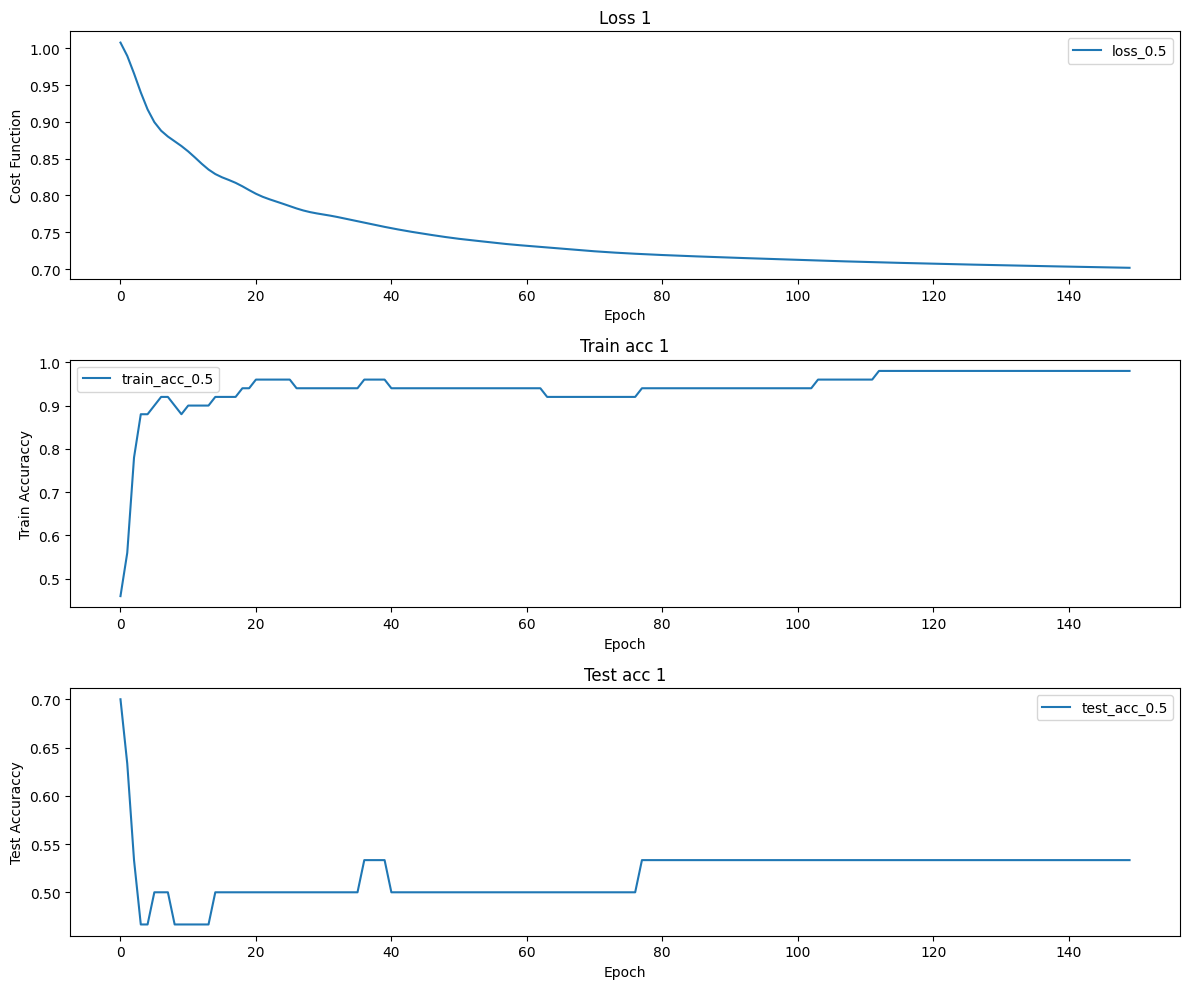

[[[ 0.67931907  0.31853655  0.41084824  0.42676732]]

 [[ 0.00765362 -0.01377284 -0.00122712 -0.02257756]]

 [[ 0.25261964 -0.32307781 -0.15928716  0.16249774]]]


In [21]:
import time
learning_rate = [0.5]
num_layers = [1]
for n_layers in num_layers:
    lrate = 0.5
    print("number layers:", n_layers)

    opt = MomentumOptimizer(lrate)
    current_cost_list = []
    acc_list = []
    test_acc_list = []
    epoch = []
    for it in range(150):
        start_time = time.time()
        # apply drop out
        dropped_parameters, masked_matrix = make_drop_out_parameter(params[1], 0.0)
        dropped_params = (params[0], dropped_parameters)
        gradient_value, current_cost = opt.compute_grad(objective_fn=cost, args=dropped_params, kwargs={"X": X, "Y": Y})
        dropped_gradient = (gradient_value[0], gradient_value[1] * masked_matrix)
        params = opt.apply_grad(grad=dropped_gradient, args=params)
        current_cost = cost(params[0],params[1], X=X, Y=Y)
        current_cost_list.append(current_cost)
        weights = params[0]
        parameters = params[1]
        # Compute accuracy on train
        predictions = [np.sign(full_circuit(x,weights,parameters=parameters,num_layers=n_layers)) for x in X_batch]
        acc = accuracy(Y_batch, predictions)
        acc_list.append(acc)
        
        # Compute accuracy on test
        predictions_test = [np.sign(full_circuit(x,weights,parameters=parameters, num_layers=n_layers)) for x in X_test_batch]
        test_acc = accuracy(Y_test_batch, predictions)
        test_acc_list.append(test_acc)
        epoch.append(it)
        
        # Redraw the updated plot
        end_time = time.time() - start_time
        print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f} | Test Accuracy: {test_acc:0.7f} | Run Time: {end_time:0.7f}")   
    draw_result(current_cost_list,acc_list,test_acc_list,epoch,lrate,n_layers)
    print(weights)

In [22]:
# Compute accuracy
weights = params[0]
parameters = params[1]
predictions = [np.sign(full_circuit(x,weights,parameters, 1)) for x in X_test]
acc = accuracy(Y_test, predictions)
print(f"Final test, accuracy_test: {acc}")

Final test, accuracy_test: 0.43333333333333335
